In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import math
import glob
import time
from datetime import date
from typing import Tuple, Union

import numpy as np
import pandas as pd
import pydicom
from tqdm import tqdm_notebook as tqdm
import cv2
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit


2024-12-20 18:49:14.850053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734720554.871476  231544 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734720554.878100  231544 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#--------------------- for working with directory ----------------------------
ROOT_DATA_PATH='/workspace/datasets'
DATASET_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-hemorrhage-detection'

TRAIN_DATA_PATH=f'{DATASET_PATH}/stage_2_train'
TRAIN_SINOGRAM_DATA_PATH=f'{DATASET_PATH}/stage_2_train_sinogram'
TRAIN_METADATA_PATH=f'{DATASET_PATH}/processed_metadata/train_metadata_df.pkl'

SEED = 666

In [3]:
IMG_SIZE = (360, 362)
IMG_SHAPE = (*IMG_SIZE, 3)

In [4]:
#seeding
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [5]:
def read_sinogram(fpath):
    im = None
    try:
        im = np.load(fpath).astype(np.float32)
    except Exception as e:
        print('\nWarning:', e.__class__.__name__, f'for {fpath} Replacing with zeros sinogram values')
        im = np.zeros(IMG_SHAPE, dtype=np.float32)
    return im

In [6]:
class TrainSinoDataGenerator(keras.utils.Sequence):
    def __init__(self, img_ids, labels, img_dir, img_shape, num_classes, batch_size, under_sampling=False, shuffle_on_epoch_end=True, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.img_ids = img_ids
        self.labels = labels
        self.img_dir = img_dir
        self.img_shape = img_shape
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.under_sampling = under_sampling
        self.shuffle_on_epoch_end = shuffle_on_epoch_end
        self.on_epoch_end()
    
    def __len__(self):
        return math.ceil(len(self.img_ids) / self.batch_size)

    def __getitem__(self, index):
        low = index*self.batch_size
        high = min(low + self.batch_size, len(self.img_ids))
        indices = self.indices[low:high]
        X,y = self.__data_generation(indices)

        return X,y
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.img_ids))
        
        if self.under_sampling:
            keep_prob = self.labels.iloc[:,0].map({0: 0.35, 1: 0.5})
            keep = (keep_prob > np.random.rand(len(keep_prob)))
            self.indices = self.indices[keep]
            
        if self.shuffle_on_epoch_end:
            np.random.shuffle(self.indices)

        
    def __data_generation(self, indices):
        X = np.empty((self.batch_size, *self.img_shape))
        y = np.empty((self.batch_size, self.num_classes), dtype=np.float32)
        
        for i, img_idx in enumerate(indices):
            img_id = self.img_ids[img_idx]
            img_path = f'{self.img_dir}/{img_id}.npy'
            img = read_sinogram(img_path)
            X[i,] = img
            y[i,] = self.labels.iloc[img_idx].values
            
        return X,y
         

In [7]:
df = pd.read_pickle(TRAIN_METADATA_PATH)
test_df_neg = df[df['Label']['any'] == 0].sample(n=200)
test_df_pos = df[df['Label']['any'] == 1].sample(n=200)
test_df = pd.concat([test_df_pos, test_df_neg]).sample(frac=1)
df = df.drop(test_df.index)
df

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_99196d0ab     1        0                0                0            0   
ID_2b0190b58     0        0                0                0            0   
ID_056e14224     1        1                0                0            0   
ID_525e72262     0        0                0                0            0   
ID_b00eddf10     0        0                0                0            0   
...            ...      ...              ...              ...          ...   
ID_21e825c20     0        0                0                0            0   
ID_85141c704     1        0                1                0            0   
ID_b4add57dd     0        0                0                0            0   
ID_02f0d7dbb     0        0                0                0            0   
ID_7d29263ce     1        0                0                0            0   

                       
Diagnosis    subdural  
Image                  
ID_99196d0ab        1  
ID_2b0190b58        0  
ID_056e14224        0  
ID_525e72262        0  
ID_b00eddf10        0  
...               ...  
ID_21e825c20        0  
ID_85141c704        1  
ID_b4add57dd        0  
ID_02f0d7dbb        0  
ID_7d29263ce        1  

[263606 rows x 6 columns]

In [8]:
df['Label']['any'].value_counts()

any
0    146510
1    117096
Name: count, dtype: int64

In [9]:
test_df['Label']['any'].value_counts()

any
1    200
0    200
Name: count, dtype: int64

In [10]:
class SinoDeepModel():
    def __init__(self, base,input_shape, batch_size, num_epochs, num_classes, learning_rate, decay_rate, decay_steps, base_name='base_model', weights='imagenet', freeze_base=False, saving_path=None, verbose=1):
        self.base = base
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.base_name = base_name
        self.weights = weights
        self.freeze_base = freeze_base
        self.saving_path = saving_path
        self.verbose = verbose
        self._build()
        self._create_saving_path_if_none()
    
    def _build(self):
        K.clear_session()
        base = self.base(include_top=False, weights=self.weights, pooling='avg', input_shape=self.input_shape)
        base.trainable = not self.freeze_base
            
        x = base.output
        x = layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4))(x)
        x = layers.Dropout(0.3)(x)
        out = layers.Dense(self.num_classes, activation='sigmoid', name='dense_output')(x)
        
        self.model = keras.models.Model(inputs=base.input, outputs=out)
        
        
        self.model.compile(
            loss=keras.losses.BinaryCrossentropy(), 
            optimizer=keras.optimizers.AdamW(learning_rate=self.learning_rate),
            metrics=[
                keras.metrics.TruePositives(name='tp'),
                keras.metrics.TrueNegatives(name='tn'),
                keras.metrics.FalsePositives(name='fp'),
                keras.metrics.FalseNegatives(name='fn'),
                keras.metrics.BinaryAccuracy(name='binary_acc'), 
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall'),
                keras.metrics.AUC(name='auc_roc', curve='ROC', multi_label=True, num_labels=self.num_classes),
                keras.metrics.AUC(name='auc_pr', curve='PR', multi_label=True, num_labels=self.num_classes),
                keras.metrics.F1Score(name='f1_score', average='weighted'),                
            ]
        )
        
    def _create_saving_path_if_none(self):
        if self.saving_path is None:
            print('saving_path is None. Automatically create path for save training utilities')
            saving_path = os.path.join('saved_model', self.base.__name__)
            os.makedirs(saving_path, exist_ok=True)
            self.saving_path = saving_path
            print(self.saving_path, 'created for saving_path')
        
    def fit(self, train_df, valid_df):
        train_data_gen = TrainSinoDataGenerator(
            img_ids=train_df.index, 
            labels=train_df,
            img_dir=TRAIN_SINOGRAM_DATA_PATH,
            img_shape=self.input_shape,
            num_classes=self.num_classes,
            batch_size=self.batch_size,
            under_sampling=False,
            workers=128,
            use_multiprocessing=True
        )
        
        valid_data_gen = TrainSinoDataGenerator(
            img_ids=valid_df.index, 
            labels=valid_df,
            img_dir=TRAIN_SINOGRAM_DATA_PATH,
            img_shape=self.input_shape,
            num_classes=self.num_classes,
            batch_size=self.batch_size,
            under_sampling=False,
            workers=128,
            use_multiprocessing=True
        )
        
        curr_time = int(time.time())
        callbacks = [
            keras.callbacks.ModelCheckpoint(filepath='%s/{epoch:02d}-%s.weights.h5' % (self.saving_path, curr_time), monitor='val_loss', mode='min', verbose=self.verbose, save_weights_only=True, save_best_only=False),
            keras.callbacks.LearningRateScheduler(lambda epoch: self.learning_rate * pow(self.decay_rate, math.floor(epoch / self.decay_steps)), verbose=1),
            keras.callbacks.EarlyStopping(verbose=1, restore_best_weights=True, monitor='val_loss', patience=5, mode='min'),
            keras.callbacks.CSVLogger(filename='%s/%s.csv'%(self.saving_path, f'{curr_time}-train_log'))
        ]
        return self.model.fit(
            x=train_data_gen,
            validation_data=valid_data_gen,
            callbacks=callbacks,
            epochs=self.num_epochs,
            verbose=self.verbose
        )
    
    def save(self, filename, overwrite=True):
        _, ext = os.path.splitext(filename)
        if ext != '.keras':
          filename = f'{filename}.keras'
          
        p = os.path.join(self.saving_path, filename)
        self.model.save(p, overwrite=overwrite)
        print('model saved to:', p)
        
    def load_weights(self, path, *args, **kwargs):
        self.model.load_weights(path, *args, **kwargs)
        
    def load(self, path, *args, **kwargs):
        self.model = keras.models.load_model(path, *args, **kwargs)
        

In [12]:
EPOCH = 15
INPUT_SHAPE = IMG_SHAPE
BATCH_SIZE = 32
N_CLASSES = 6
INITIAL_LEARNING_RATE = 0.000125

In [13]:
msss = MultilabelStratifiedShuffleSplit(n_splits=EPOCH, test_size=0.15, random_state=SEED)
X = df.index
Y = df['Label'].values

msss_splits = next(msss.split(X, Y))
train_idx = msss_splits[0]
valid_idx = msss_splits[1]

In [14]:
saving_path = 'saved_model/02_EfficientNetB4_V2_sinogram_input'
os.makedirs(saving_path, exist_ok=True)

model = SinoDeepModel(
    base=keras.applications.EfficientNetB4,
    weights='imagenet',
    freeze_base=False,
    input_shape=INPUT_SHAPE, 
    batch_size=BATCH_SIZE, 
    num_epochs=EPOCH,
    num_classes=N_CLASSES,
    learning_rate=INITIAL_LEARNING_RATE, 
    decay_rate=0.75, 
    decay_steps=1,
    base_name='efficientnetb4',
    saving_path=saving_path
)

I0000 00:00:1734720614.361320  231544 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8225 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 1g.10gb, pci bus id: 0000:07:00.0, compute capability: 8.0


In [ ]:
np.random.shuffle(train_idx)

hist = model.fit(df.iloc[train_idx], df.iloc[valid_idx])
model.save('Best_EfficientNetB4_V2_sinogram_input.keras')


Epoch 1: LearningRateScheduler setting learning rate to 0.000125.
Epoch 1/15


I0000 00:00:1734720722.674747  232086 service.cc:148] XLA service 0x7fd79c148930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734720722.674783  232086 service.cc:156]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 1g.10gb, Compute Capability 8.0
I0000 00:00:1734720732.146908  232086 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1734720746.047711  232086 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1734720746.235108  232086 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
I0000 00:00:1734720808.376626  232086 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3419/7003 ━━━━━━━━━━━━━━━━━━━━ 47:23 793ms/step - auc_pr: 0.4562 - auc_roc: 0.8022 - binary_acc: 0.8622 - f1_score: 0.2985 - fn: 30740.3008 - fp: 11221.6738 - loss: 0.3414 - precision: 0.6748 - recall: 0.4399 - tn: 258677.1250 - tp: 27680.8945

In [ ]:
logpath = os.path.join(model.saving_path, '1734720621-train_log.csv') 
train_history = pd.read_csv(logpath)
# train_history['epoch'] = train_history['epoch']+1
# train_history.to_csv(logpath, index=False)
train_history

In [24]:
train_history

,epoch,auc_pr,auc_roc,binary_acc,f1_score,fn,fp,learning_rate,loss,precision,...,val_auc_roc,val_binary_acc,val_f1_score,val_fn,val_fp,val_loss,val_precision,val_recall,val_tn,val_tp
0,1,0.677939,0.902376,0.898030,0.290773,99915.0,37193.0,0.000125,0.246951,0.788717,...,0.502404,0.822200,0.034051,42194.0,0.0,1.163626,0.000000,0.000000,195118.0,0.0
1,2,0.835790,0.949585,0.926492,0.335186,67554.0,31281.0,0.000094,0.180851,0.845517,...,0.838561,0.864158,0.304548,31065.0,1172.0,0.370763,0.904754,0.263828,193942.0,11133.0
2,3,0.898778,0.970401,0.944318,0.364277,48953.0,25917.0,0.000070,0.138374,0.879857,...,0.895679,0.887806,0.335951,15618.0,11007.0,0.289950,0.707136,0.629861,184110.0,26577.0
3,4,0.941150,0.984184,0.960184,0.390160,33607.0,19929.0,0.000053,0.100480,0.911456,...,0.742874,0.855161,0.351314,32584.0,1788.0,0.682671,0.843185,0.227831,193326.0,9614.0
4,5,0.967356,0.991865,0.972573,0.407937,22508.0,14368.0,0.000040,0.070893,0.937700,...,0.833068,0.889866,0.388403,23057.0,3079.0,0.435737,0.861419,0.453574,192037.0,19139.0
5,6,0.981696,0.995680,0.980980,0.420612,15323.0,10251.0,0.000030,0.050443,0.956131,...,0.887579,0.901464,0.397929,17307.0,6077.0,0.392863,0.803797,0.589911,189032.0,24896.0
6,7,0.989019,0.997472,0.986045,0.429793,11012.0,7752.0,0.000022,0.037701,0.967083,...,0.888846,0.912268,0.418425,16822.0,3998.0,0.395977,0.863903,0.601374,191114.0,25378.0


In [27]:
def plot_hist(train_history, best_epoch):
    best = lambda idx, x_col, y_col: (train_history.iloc[idx][x_col],train_history.iloc[idx][y_col])
    # best_epoch = 3
    # Set seaborn theme
    sns.set_theme(style="whitegrid")

    # Create the figure and axes
    fig, axes = plt.subplots(3, 3, figsize=(26, 18), sharey=False)
    fig.suptitle("Training History", fontsize=18, fontweight="bold", color="darkblue")

    # 1st subplot: AUC-ROC
    sns.lineplot(data=train_history, x='epoch', y='auc_roc', label='Train AUC-ROC', ax=axes[0, 0], color='blue', linewidth=2, marker='o')
    sns.lineplot(data=train_history, x='epoch', y='val_auc_roc', label='Validation AUC-ROC', ax=axes[0, 0], color='orange', linewidth=2, marker='o')
    # lambda arguments : expression
    # axes[0].annotate(text='best', xy=best('epoch', 'val_auc_roc'))
    axes[0, 0].set_ylabel("AUC-ROC", fontsize=14)
    axes[0, 0].set_title("AUC-ROC vs. Epochs", fontsize=14)
    axes[0, 0].legend(loc="lower right", fontsize=10)

    # 2nd subplot: AUC-PR
    sns.lineplot(data=train_history, x='epoch', y='auc_pr', label='Train AUC-PR', ax=axes[0, 1], color='blue', linewidth=2, marker='o')
    sns.lineplot(data=train_history, x='epoch', y='val_auc_pr', label='Validation AUC-PR', ax=axes[0, 1], color='orange', linewidth=2, marker='o')
    # lambda arguments : expression
    # axes[0].annotate(text='best', xy=best('epoch', 'val_auc_roc'))
    axes[0, 1].set_ylabel("AUC-PR", fontsize=14)
    axes[0, 1].set_title("AUC-PR vs. Epochs", fontsize=14)
    axes[0, 1].legend(loc="lower right", fontsize=10)

    # 3rd subplot: Accuracy
    sns.lineplot(data=train_history, x='epoch', y='binary_acc', label='Train Accuracy', ax=axes[0, 2], color='blue', linewidth=2, marker='o')
    sns.lineplot(data=train_history, x='epoch', y='val_binary_acc', label='Validation Accuracy', ax=axes[0, 2], color='orange', linewidth=2, marker='o')
    # axes[2].annotate(text='best', xy=best('epoch', 'val_loss'))
    axes[0, 2].set_ylabel("Accuracy", fontsize=14)
    axes[0, 2].set_title("Accuracy vs. Epochs", fontsize=14)
    axes[0, 2].legend(loc="lower right", fontsize=10)

    # 4th subplot: Loss
    sns.lineplot(data=train_history, x='epoch', y='loss', label='Train Loss', ax=axes[1, 0], color='blue', linewidth=2, marker='o')
    sns.lineplot(data=train_history, x='epoch', y='val_loss', label='Validation Loss', ax=axes[1, 0], color='orange', linewidth=2, marker='o')
    axes[1, 0].annotate(text='best', xy=best(best_epoch-1, 'epoch', 'val_loss'))
    axes[1, 0].set_ylabel("Loss", fontsize=14)
    axes[1, 0].set_title("Loss vs. Epochs", fontsize=14)
    axes[1, 0].legend(loc="lower left", fontsize=10)


    # 5th subplot: F1-Score
    sns.lineplot(data=train_history, x='epoch', y='f1_score', label='Train F1-Score', ax=axes[1, 1], color='blue', linewidth=2, marker='o')
    sns.lineplot(data=train_history, x='epoch', y='val_f1_score', label='Validation  F1-Score', ax=axes[1, 1], color='orange', linewidth=2, marker='o')
    # axes[1].annotate(text='best', xy=best('epoch', 'val_loss'))
    axes[1, 1].set_ylabel("F1-Score", fontsize=14)
    axes[1, 1].set_title("F1-Score vs. Epochs", fontsize=14)
    axes[1, 1].legend(loc="lower left", fontsize=10)

    # 6th subplot: Precision
    sns.lineplot(data=train_history, x='epoch', y='precision', label='Train Precision', ax=axes[1, 2], color='blue', linewidth=2, marker='o')
    sns.lineplot(data=train_history, x='epoch', y='val_precision', label='Validation Precision', ax=axes[1, 2], color='orange', linewidth=2, marker='o')
    # axes[1].annotate(text='best', xy=best('epoch', 'val_precision'))
    axes[1, 2].set_ylabel("Precision", fontsize=14)
    axes[1, 2].set_title("Precision vs. Epochs", fontsize=14)
    axes[1, 2].legend(loc="lower left", fontsize=10)

    # 7th subplot: Recall
    sns.lineplot(data=train_history, x='epoch', y='recall', label='Train Recall', ax=axes[2, 0], color='blue', linewidth=2, marker='o')
    sns.lineplot(data=train_history, x='epoch', y='val_recall', label='Validation Recall', ax=axes[2, 0], color='orange', linewidth=2, marker='o')
    # axes[1].annotate(text='best', xy=best('epoch', 'val_recall'))
    axes[2, 0].set_ylabel("Recall", fontsize=14)
    axes[2, 0].set_title("Recall vs. Epochs", fontsize=14)
    axes[2, 0].legend(loc="lower left", fontsize=10)


    # confusion matrix from best weight
    row = train_history[train_history['epoch'] == best_epoch].iloc[0]

    conf_matrix_training = [
        [int(row['tn']), int(row['fp'])], # [TN, FP]
        [int(row['fn']), int(row['tp'])], # [FN, TP]
    ]
    conf_matrix_validation = [
        [int(row['val_tn']), int(row['val_fp'])],
        [int(row['val_fn']), int(row['val_tp'])],
    ]

    # 8th subplot: Training Confusiong Matrix
    sns.heatmap(conf_matrix_training, annot=True, fmt='d', cmap='Blues', cbar=False,ax=axes[2, 1], xticklabels=["Predicted Negative", "Predicted Positive"], yticklabels=["Actual Negative", "Actual Positive"])
    axes[2, 1].set_title("Training Confusion Matrix for Epoch-6", pad=30, fontdict={'fontweight': 'bold'})

    # 9th subplot: Validation Confusiong Matrix
    sns.heatmap(conf_matrix_validation, annot=True, fmt='d', cmap='Blues', cbar=False,ax=axes[2, 2], xticklabels=["Predicted Negative", "Predicted Positive"], yticklabels=["Actual Negative", "Actual Positive"])
    axes[2, 2].set_title("Validation Confusion Matrix for Epoch-6", pad=30, fontdict={'fontweight': 'bold'})

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 1])  # Leave space for suptitle
    plt.show()

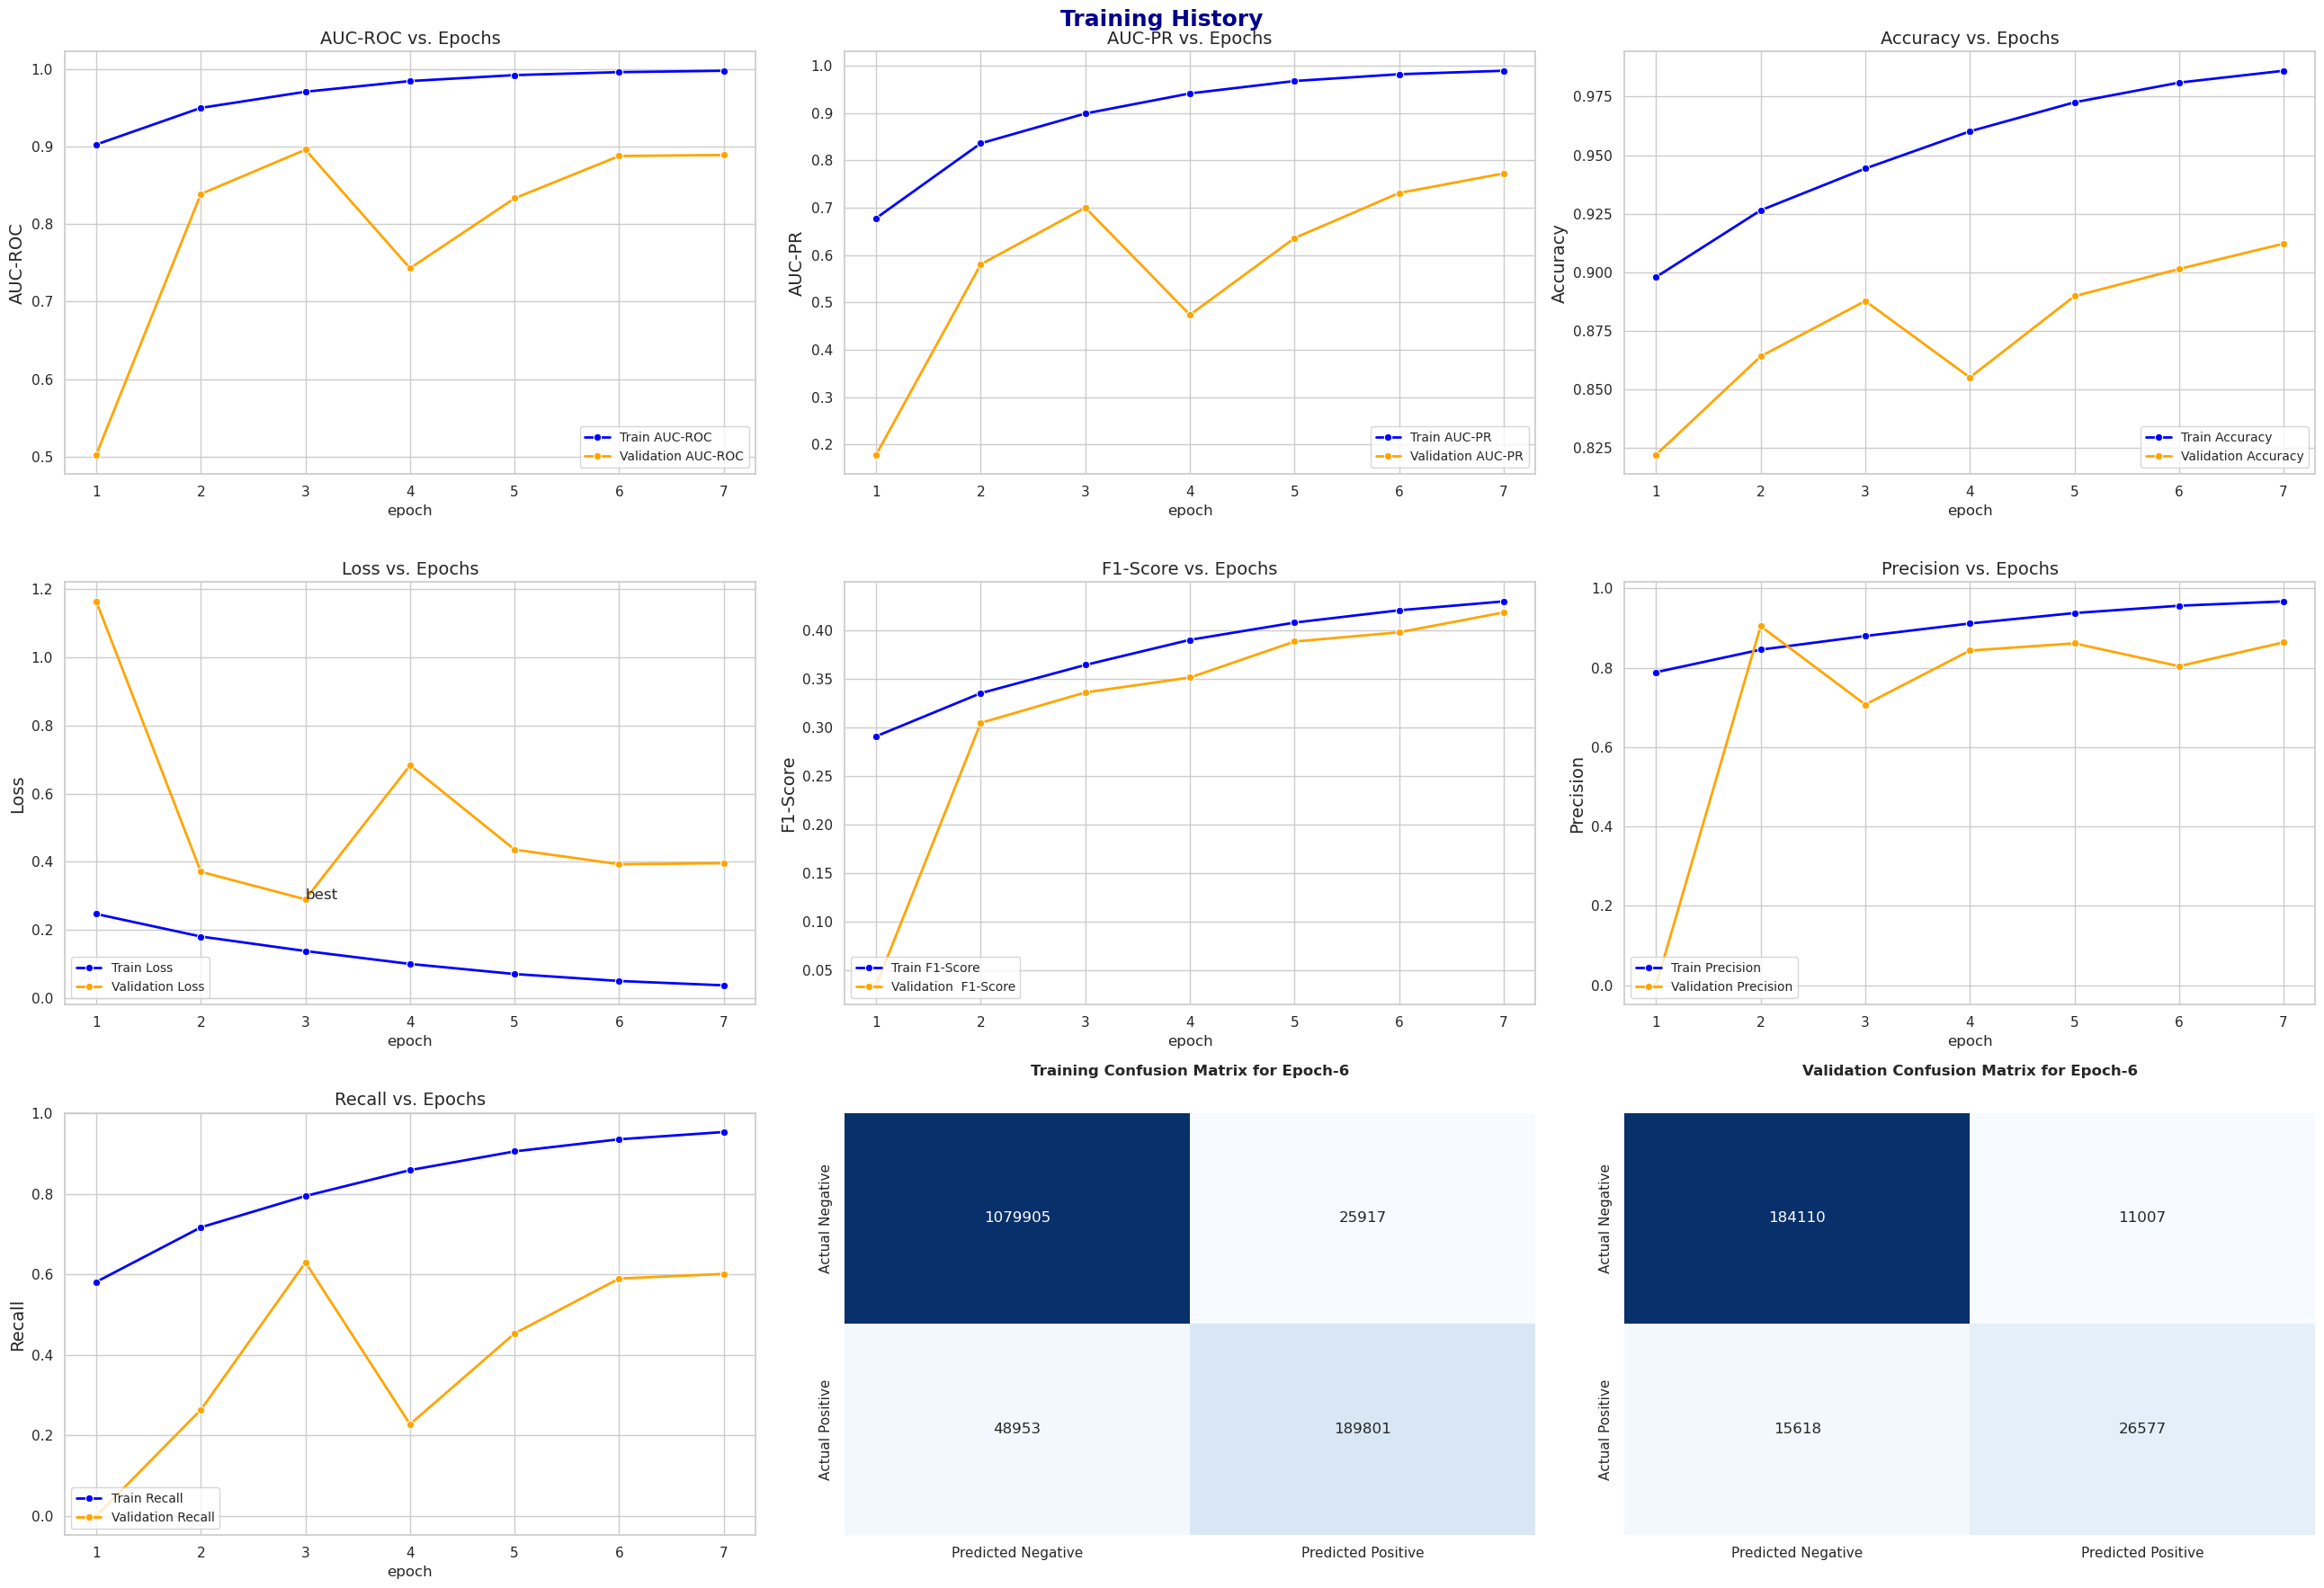

In [28]:
plot_hist(train_history, 3)

In [30]:
prev_train_history = pd.read_csv('/workspace/saved_model/EfficientNetB4_Sino/1734357960-train_log.csv')
prev_train_history['val_loss']

0    1.168819
1    1.234129
2    0.382581
3    0.287130
4    0.319525
5    0.189986
6    0.192260
7    0.179622
8    0.179839
9    0.178622
Name: val_loss, dtype: float64